In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from surprise import accuracy
from surprise import KNNWithMeans
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import PredefinedKFold, GridSearchCV, train_test_split, cross_validate

In [2]:
'''
http://files.grouplens.org/datasets/movielens/ml-100k-README.txt
'''

# Attributes in the data file are tab separated (\t).
# User = user_id
# Item = item_id
# Rating = rating
# Timestamp = timestamp
reader = Reader(line_format="user item rating timestamp", sep="\t", rating_scale=(1,5))

train_set = Dataset.load_from_file('./ml-100k/u1.base', reader=reader)

In [4]:
algorithm = KNNWithMeans()

# Run 5-fold cross-validation and print results
baseline_results = cross_validate(algorithm, train_set, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9537  0.9490  0.9539  0.9618  0.9575  0.9552  0.0043  
MAE (testset)     0.7550  0.7492  0.7481  0.7557  0.7551  0.7526  0.0033  
Fit time          0.31    0.36    0.32    0.31    0.32    0.32    0.02    
Test time         3.24    3.13    3.23    2.94    2.92    3.09    0.14    


##### Tune the model

In [5]:
param_grid = {'k': [i for i in range(40, 130, 10)],
              'min_k': [1, 2, 3, 4, 5],
              'sim_options': {'name': ['msd', 'cosine', 'pearson']},
              'verbose': [False]
             }
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(train_set)

In [6]:
gs.best_params

{'rmse': {'k': 60,
  'min_k': 4,
  'sim_options': {'name': 'msd', 'user_based': True},
  'verbose': False},
 'mae': {'k': 90,
  'min_k': 4,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'verbose': False}}

In [7]:
gs.best_score

{'rmse': 0.9535668451522689, 'mae': 0.7479397964632434}

In [8]:
tuning_results = pd.DataFrame.from_dict(gs.cv_results)

In [9]:
tuning_results["sim_type"] = tuning_results["param_sim_options"].apply(lambda x: x['name'])

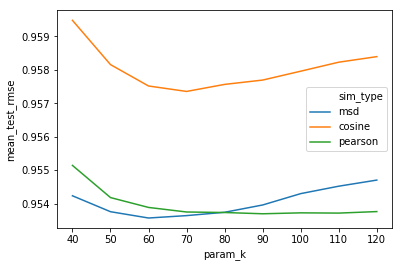

In [11]:
sns.lineplot(x="param_k", y="mean_test_rmse", hue="sim_type", data=tuning_results[tuning_results["param_min_k"] == 4])

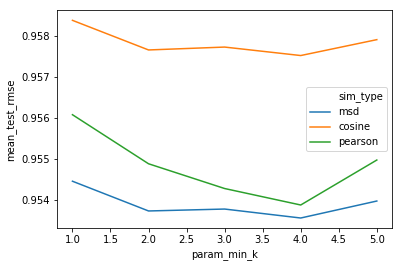

In [13]:
sns.lineplot(x="param_min_k", y="mean_test_rmse", hue="sim_type", data=tuning_results[tuning_results["param_k"] == 60])

##### Compare performance between baseline and tuned models on test set

In [14]:
# Load test set
folds_files = [("./ml-100k/u1.base", "./ml-100k/u1.test")]
data = Dataset.load_from_folds(folds_files, reader=reader)
pkf = PredefinedKFold()

test_set = None
for _, s in pkf.split(data):
    test_set = s

In [15]:
# Baseline model
accuracy.rmse(algorithm.test(test_set))

RMSE: 0.9761


0.9761268826989099

In [16]:
# Tuned model
tuned_model = gs.best_estimator["rmse"]
tuned_model.fit(train_set.build_full_trainset())

In [17]:
accuracy.rmse(tuned_model.test(test_set))

RMSE: 0.9649


0.9649021293521403

The tuned model performs similarly to the baseline model on the test set.